In [ ]:
! pip install numpy==1.17

In [ ]:
!pip uninstall pycocotools -y
!pip install -q git+https://github.com/waleedka/coco.git#subdirectory=PythonAPI

Uninstalling pycocotools-2.0:
  Successfully uninstalled pycocotools-2.0


In [ ]:
!pip install hydra-core
!pip install pytorch-lightning==0.8.1

In [ ]:
! pip install albumentations==0.4.6

In [ ]:
!pip install ensemble_boxes

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Import libraries

In [ ]:
from __future__ import print_function
from PIL import Image
from albumentations.core.composition import Compose
from collections import defaultdict, deque
from itertools import product
from omegaconf import DictConfig, OmegaConf
from pycocotools import mask as coco_mask
from pycocotools.coco import COCO
from pycocotools.cocoeval import COCOeval
from pytorch_lightning.loggers import TensorBoardLogger
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset
from torchvision.transforms import functional as F
from typing import Any, Dict, List
import albumentations as A
import ast
import copy
import cv2
import datetime
import errno
import hydra
import importlib
import json
import numpy as np
import os
import pandas as pd
import pickle
import pycocotools.mask as mask_util
import pytorch_lightning as pl
import random
import shutil
import tempfile
import time
import torch
import torch._six
import torch.distributed as dist
import torch.utils.data
import torchvision
import matplotlib.pyplot as plt
import collections
from tqdm import tqdm
from ensemble_boxes import *
%matplotlib inline

In [ ]:
os.makedirs('data', exist_ok = True)

In [ ]:
!unzip /content/drive/MyDrive/Datasets/archive.zip -d data

Streaming output truncated to the last 5000 lines.
  inflating: data/train/train/a9f32aee073a0ee7ea94e959ab63885c.jpg  
  inflating: data/train/train/a9f467688d104d27583ea3b3154b1f30.jpg  
  inflating: data/train/train/a9f4c9a4971b3877981e09d4a2ac7fc0.jpg  
  inflating: data/train/train/a9f60e50925ece0b5c00b6bbd9f0825c.jpg  
  inflating: data/train/train/aa0202259a3cba71d0e72468e2d9c3e2.jpg  
  inflating: data/train/train/aa08370eb6114a474adfd0accb6a7238.jpg  
  inflating: data/train/train/aa0a24df022cd97cc1dff4f7ea2131cc.jpg  
  inflating: data/train/train/aa0b79c06462e126d97b73a15187c9c4.jpg  
  inflating: data/train/train/aa1203b1ecab0cddec19f07eb68d4dee.jpg  
  inflating: data/train/train/aa12ea6652b3b8bea37df74e4e127e8f.jpg  
  inflating: data/train/train/aa161d1deb918990c3e196501a714994.jpg  
  inflating: data/train/train/aa1758ce7d9f3cb0bbba72d163ffc69a.jpg  
  inflating: data/train/train/aa17d5312a0fb4a2939436abca7f9579.jpg  
  inflating: data/train/train/aa1c58360809119ce5c2d0

### Weighted Boxes Fusion

In [ ]:
# ===============================
iou_thr = 0.5
skip_box_thr = 0.001
sigma = 0.1
# ===============================

# Loading the train DF
df = pd.read_csv("data/train_downsampled.csv")
df.fillna(0, inplace=True)
df.loc[df["class_id"] == 14, ['x_max', 'y_max']] = 1.0

results = []
image_ids = df["image_id"].unique()

for image_id in tqdm(image_ids, total=len(image_ids)):

    # All annotations for the current image.
    data = df[df["image_id"] == image_id]
    data = data.reset_index(drop=True)

    annotations = {}
    weights = []

    # WBF expects the coordinates in 0-1 range.
    max_value = data.iloc[:, 4:].values.max()
    data.loc[:, ["x_min", "y_min", "x_max", "y_max"]] = data.iloc[:, 4:] / max_value

    # Loop through all of the annotations
    for idx, row in data.iterrows():

        rad_id = row["rad_id"]

        if rad_id not in annotations:
            annotations[rad_id] = {
                "boxes_list": [],
                "scores_list": [],
                "labels_list": [],
            }

            # We consider all of the radiologists as equal.
            weights.append(1.0)

        annotations[rad_id]["boxes_list"].append([row["x_min"], row["y_min"], row["x_max"], row["y_max"]])
        annotations[rad_id]["scores_list"].append(1.0)
        annotations[rad_id]["labels_list"].append(row["class_id"])

    boxes_list = []
    scores_list = []
    labels_list = []

    for annotator in annotations.keys():
        boxes_list.append(annotations[annotator]["boxes_list"])
        scores_list.append(annotations[annotator]["scores_list"])
        labels_list.append(annotations[annotator]["labels_list"])

    # Calculate WBF
    boxes, scores, labels = weighted_boxes_fusion(
        boxes_list,
        scores_list,
        labels_list,
        weights=weights,
        iou_thr=iou_thr,
        skip_box_thr=skip_box_thr
    )

    for idx, box in enumerate(boxes):
        results.append({
            "image_id": image_id,
            "class_id": int(labels[idx]),
            "rad_id": "wbf",
            "x_min": box[0] * max_value,
            "y_min": box[1] * max_value,
            "x_max": box[2] * max_value,
            "y_max": box[3] * max_value,
        })

results = pd.DataFrame(results)
results.to_csv('data/train.csv')

100%|██████████| 15000/15000 [01:49<00:00, 137.20it/s]


### Helper functions



In [ ]:
# different small utils

class SmoothedValue(object):
    """Track a series of values and provide access to smoothed values over a
    window or the global series average.
    """

    def __init__(self, window_size=20, fmt=None):
        if fmt is None:
            fmt = "{median:.4f} ({global_avg:.4f})"
        self.deque = deque(maxlen=window_size)
        self.total = 0.0
        self.count = 0
        self.fmt = fmt

    def update(self, value, n=1):
        self.deque.append(value)
        self.count += n
        self.total += value * n

    def synchronize_between_processes(self):
        """
        Warning: does not synchronize the deque!
        """
        if not is_dist_avail_and_initialized():
            return
        t = torch.tensor([self.count, self.total], dtype=torch.float64, device='cuda')
        dist.barrier()
        dist.all_reduce(t)
        t = t.tolist()
        self.count = int(t[0])
        self.total = t[1]

    @property
    def median(self):
        d = torch.tensor(list(self.deque))
        return d.median().item()

    @property
    def avg(self):
        d = torch.tensor(list(self.deque), dtype=torch.float32)
        return d.mean().item()

    @property
    def global_avg(self):
        return self.total / self.count

    @property
    def max(self):
        return max(self.deque)

    @property
    def value(self):
        return self.deque[-1]

    def __str__(self):
        return self.fmt.format(
            median=self.median,
            avg=self.avg,
            global_avg=self.global_avg,
            max=self.max,
            value=self.value)


def all_gather(data):
    """
    Run all_gather on arbitrary picklable data (not necessarily tensors)
    Args:
        data: any picklable object
    Returns:
        list[data]: list of data gathered from each rank
    """
    world_size = get_world_size()
    if world_size == 1:
        return [data]

    # serialized to a Tensor
    buffer = pickle.dumps(data)
    storage = torch.ByteStorage.from_buffer(buffer)
    tensor = torch.ByteTensor(storage).to("cuda")

    # obtain Tensor size of each rank
    local_size = torch.tensor([tensor.numel()], device="cuda")
    size_list = [torch.tensor([0], device="cuda") for _ in range(world_size)]
    dist.all_gather(size_list, local_size)
    size_list = [int(size.item()) for size in size_list]
    max_size = max(size_list)

    # receiving Tensor from all ranks
    # we pad the tensor because torch all_gather does not support
    # gathering tensors of different shapes
    tensor_list = []
    for _ in size_list:
        tensor_list.append(torch.empty((max_size,), dtype=torch.uint8, device="cuda"))
    if local_size != max_size:
        padding = torch.empty(size=(max_size - local_size,), dtype=torch.uint8, device="cuda")
        tensor = torch.cat((tensor, padding), dim=0)
    dist.all_gather(tensor_list, tensor)

    data_list = []
    for size, tensor in zip(size_list, tensor_list):
        buffer = tensor.cpu().numpy().tobytes()[:size]
        data_list.append(pickle.loads(buffer))

    return data_list


def reduce_dict(input_dict, average=True):
    """
    Args:
        input_dict (dict): all the values will be reduced
        average (bool): whether to do average or sum
    Reduce the values in the dictionary from all processes so that all processes
    have the averaged results. Returns a dict with the same fields as
    input_dict, after reduction.
    """
    world_size = get_world_size()
    if world_size < 2:
        return input_dict
    with torch.no_grad():
        names = []
        values = []
        # sort the keys so that they are consistent across processes
        for k in sorted(input_dict.keys()):
            names.append(k)
            values.append(input_dict[k])
        values = torch.stack(values, dim=0)
        dist.all_reduce(values)
        if average:
            values /= world_size
        reduced_dict = {k: v for k, v in zip(names, values)}
    return reduced_dict


class MetricLogger(object):
    def __init__(self, delimiter="\t"):
        self.meters = defaultdict(SmoothedValue)
        self.delimiter = delimiter

    def update(self, **kwargs):
        for k, v in kwargs.items():
            if isinstance(v, torch.Tensor):
                v = v.item()
            assert isinstance(v, (float, int))
            self.meters[k].update(v)

    def __getattr__(self, attr):
        if attr in self.meters:
            return self.meters[attr]
        if attr in self.__dict__:
            return self.__dict__[attr]
        raise AttributeError("'{}' object has no attribute '{}'".format(
            type(self).__name__, attr))

    def __str__(self):
        loss_str = []
        for name, meter in self.meters.items():
            loss_str.append(
                "{}: {}".format(name, str(meter))
            )
        return self.delimiter.join(loss_str)

    def synchronize_between_processes(self):
        for meter in self.meters.values():
            meter.synchronize_between_processes()

    def add_meter(self, name, meter):
        self.meters[name] = meter

    def log_every(self, iterable, print_freq, header=None):
        i = 0
        if not header:
            header = ''
        start_time = time.time()
        end = time.time()
        iter_time = SmoothedValue(fmt='{avg:.4f}')
        data_time = SmoothedValue(fmt='{avg:.4f}')
        space_fmt = ':' + str(len(str(len(iterable)))) + 'd'
        log_msg = self.delimiter.join([
            header,
            '[{0' + space_fmt + '}/{1}]',
            'eta: {eta}',
            '{meters}',
            'time: {time}',
            'data: {data}',
            'max mem: {memory:.0f}'
        ])
        MB = 1024.0 * 1024.0
        for obj in iterable:
            data_time.update(time.time() - end)
            yield obj
            iter_time.update(time.time() - end)
            if i % print_freq == 0 or i == len(iterable) - 1:
                eta_seconds = iter_time.global_avg * (len(iterable) - i)
                eta_string = str(datetime.timedelta(seconds=int(eta_seconds)))
                print(log_msg.format(
                    i, len(iterable), eta=eta_string,
                    meters=str(self),
                    time=str(iter_time), data=str(data_time),
                    memory=torch.cuda.max_memory_allocated() / MB))
            i += 1
            end = time.time()
        total_time = time.time() - start_time
        total_time_str = str(datetime.timedelta(seconds=int(total_time)))
        print('{} Total time: {} ({:.4f} s / it)'.format(
            header, total_time_str, total_time / len(iterable)))


def collate_fn(batch):
    return tuple(zip(*batch))


def warmup_lr_scheduler(optimizer, warmup_iters, warmup_factor):

    def f(x):
        if x >= warmup_iters:
            return 1
        alpha = float(x) / warmup_iters
        return warmup_factor * (1 - alpha) + alpha

    return torch.optim.lr_scheduler.LambdaLR(optimizer, f)


def mkdir(path):
    try:
        os.makedirs(path)
    except OSError as e:
        if e.errno != errno.EEXIST:
            raise


def setup_for_distributed(is_master):
    """
    This function disables printing when not in master process
    """
    import builtins as __builtin__
    builtin_print = __builtin__.print

    def print(*args, **kwargs):
        force = kwargs.pop('force', False)
        if is_master or force:
            builtin_print(*args, **kwargs)

    __builtin__.print = print


def is_dist_avail_and_initialized():
    if not dist.is_available():
        return False
    if not dist.is_initialized():
        return False
    return True


def get_world_size():
    if not is_dist_avail_and_initialized():
        return 1
    return dist.get_world_size()


def get_rank():
    if not is_dist_avail_and_initialized():
        return 0
    return dist.get_rank()


def is_main_process():
    return get_rank() == 0


def save_on_master(*args, **kwargs):
    if is_main_process():
        torch.save(*args, **kwargs)


def init_distributed_mode(args):
    if 'RANK' in os.environ and 'WORLD_SIZE' in os.environ:
        args.rank = int(os.environ["RANK"])
        args.world_size = int(os.environ['WORLD_SIZE'])
        args.gpu = int(os.environ['LOCAL_RANK'])
    elif 'SLURM_PROCID' in os.environ:
        args.rank = int(os.environ['SLURM_PROCID'])
        args.gpu = args.rank % torch.cuda.device_count()
    else:
        print('Not using distributed mode')
        args.distributed = False
        return

    args.distributed = True

    torch.cuda.set_device(args.gpu)
    args.dist_backend = 'nccl'
    print('| distributed init (rank {}): {}'.format(
        args.rank, args.dist_url), flush=True)
    torch.distributed.init_process_group(backend=args.dist_backend, init_method=args.dist_url,
                                         world_size=args.world_size, rank=args.rank)
    torch.distributed.barrier()
    setup_for_distributed(args.rank == 0)


### coco evaluator

In [ ]:
class CocoEvaluator(object):
    def __init__(self, coco_gt, iou_types):
        assert isinstance(iou_types, (list, tuple))
        coco_gt = copy.deepcopy(coco_gt)
        self.coco_gt = coco_gt

        self.iou_types = iou_types
        self.coco_eval = {}
        for iou_type in iou_types:
            self.coco_eval[iou_type] = COCOeval(coco_gt, iouType=iou_type)

        self.img_ids = []
        self.eval_imgs = {k: [] for k in iou_types}

    def update(self, predictions):
        img_ids = list(np.unique(list(predictions.keys())))
        self.img_ids.extend(img_ids)

        for iou_type in self.iou_types:
            results = self.prepare(predictions, iou_type)
            coco_dt = loadRes(self.coco_gt, results) if results else COCO()
            coco_eval = self.coco_eval[iou_type]

            coco_eval.cocoDt = coco_dt
            coco_eval.params.imgIds = list(img_ids)
            img_ids, eval_imgs = evaluate(coco_eval)

            self.eval_imgs[iou_type].append(eval_imgs)

    def synchronize_between_processes(self):
        for iou_type in self.iou_types:
            self.eval_imgs[iou_type] = np.concatenate(self.eval_imgs[iou_type], 2)
            create_common_coco_eval(self.coco_eval[iou_type], self.img_ids, self.eval_imgs[iou_type])

    def accumulate(self):
        for coco_eval in self.coco_eval.values():
            coco_eval.evaluate()
            coco_eval.accumulate()

    def summarize(self):
        for iou_type, coco_eval in self.coco_eval.items():
            print("IoU metric: {}".format(iou_type))
            coco_eval.summarize()

    def prepare(self, predictions, iou_type):
        if iou_type == "bbox":
            return self.prepare_for_coco_detection(predictions)
        elif iou_type == "segm":
            return self.prepare_for_coco_segmentation(predictions)
        elif iou_type == "keypoints":
            return self.prepare_for_coco_keypoint(predictions)
        else:
            raise ValueError("Unknown iou type {}".format(iou_type))

    def prepare_for_coco_detection(self, predictions):
        coco_results = []
        for original_id, prediction in predictions.items():
            if len(prediction) == 0:
                continue

            boxes = prediction["boxes"]
            boxes = convert_to_xywh(boxes).tolist()
            scores = prediction["scores"].tolist()
            labels = prediction["labels"].tolist()

            coco_results.extend(
                [
                    {
                        "image_id": original_id,
                        "category_id": labels[k],
                        "bbox": box,
                        "score": scores[k],
                    }
                    for k, box in enumerate(boxes)
                ]
            )
        return coco_results

    def prepare_for_coco_segmentation(self, predictions):
        coco_results = []
        for original_id, prediction in predictions.items():
            if len(prediction) == 0:
                continue

            scores = prediction["scores"]
            labels = prediction["labels"]
            masks = prediction["masks"]

            masks = masks > 0.5

            scores = prediction["scores"].tolist()
            labels = prediction["labels"].tolist()

            rles = [
                mask_util.encode(np.array(mask[0, :, :, np.newaxis], dtype=np.uint8, order="F"))[0]
                for mask in masks
            ]
            for rle in rles:
                rle["counts"] = rle["counts"].decode("utf-8")

            coco_results.extend(
                [
                    {
                        "image_id": original_id,
                        "category_id": labels[k],
                        "segmentation": rle,
                        "score": scores[k],
                    }
                    for k, rle in enumerate(rles)
                ]
            )
        return coco_results

    def prepare_for_coco_keypoint(self, predictions):
        coco_results = []
        for original_id, prediction in predictions.items():
            if len(prediction) == 0:
                continue

            boxes = prediction["boxes"]
            boxes = convert_to_xywh(boxes).tolist()
            scores = prediction["scores"].tolist()
            labels = prediction["labels"].tolist()
            keypoints = prediction["keypoints"]
            keypoints = keypoints.flatten(start_dim=1).tolist()

            coco_results.extend(
                [
                    {
                        "image_id": original_id,
                        "category_id": labels[k],
                        'keypoints': keypoint,
                        "score": scores[k],
                    }
                    for k, keypoint in enumerate(keypoints)
                ]
            )
        return coco_results


def convert_to_xywh(boxes):
    xmin, ymin, xmax, ymax = boxes.unbind(1)
    return torch.stack((xmin, ymin, xmax - xmin, ymax - ymin), dim=1)


def merge(img_ids, eval_imgs):
    all_img_ids = all_gather(img_ids)
    all_eval_imgs = all_gather(eval_imgs)

    merged_img_ids = []
    for p in all_img_ids:
        merged_img_ids.extend(p)

    merged_eval_imgs = []
    for p in all_eval_imgs:
        merged_eval_imgs.append(p)

    merged_img_ids = np.array(merged_img_ids)
    merged_eval_imgs = np.concatenate(merged_eval_imgs, 2)

    # keep only unique (and in sorted order) images
    merged_img_ids, idx = np.unique(merged_img_ids, return_index=True)
    merged_eval_imgs = merged_eval_imgs[..., idx]

    return merged_img_ids, merged_eval_imgs


def create_common_coco_eval(coco_eval, img_ids, eval_imgs):
    img_ids, eval_imgs = merge(img_ids, eval_imgs)
    img_ids = list(img_ids)
    eval_imgs = list(eval_imgs.flatten())

    coco_eval.evalImgs = eval_imgs
    coco_eval.params.imgIds = img_ids
    coco_eval._paramsEval = copy.deepcopy(coco_eval.params)


#################################################################
# From pycocotools, just removed the prints and fixed
# a Python3 bug about unicode not defined
#################################################################

# Ideally, pycocotools wouldn't have hard-coded prints
# so that we could avoid copy-pasting those two functions

def createIndex(self):
    # create index
    # print('creating index...')
    anns, cats, imgs = {}, {}, {}
    imgToAnns, catToImgs = defaultdict(list), defaultdict(list)
    if 'annotations' in self.dataset:
        for ann in self.dataset['annotations']:
            imgToAnns[ann['image_id']].append(ann)
            anns[ann['id']] = ann

    if 'images' in self.dataset:
        for img in self.dataset['images']:
            imgs[img['id']] = img

    if 'categories' in self.dataset:
        for cat in self.dataset['categories']:
            cats[cat['id']] = cat

    if 'annotations' in self.dataset and 'categories' in self.dataset:
        for ann in self.dataset['annotations']:
            catToImgs[ann['category_id']].append(ann['image_id'])

    # print('index created!')

    # create class members
    self.anns = anns
    self.imgToAnns = imgToAnns
    self.catToImgs = catToImgs
    self.imgs = imgs
    self.cats = cats


maskUtils = mask_util


def loadRes(self, resFile):
    """
    Load result file and return a result api object.
    :param   resFile (str)     : file name of result file
    :return: res (obj)         : result api object
    """
    res = COCO()
    res.dataset['images'] = [img for img in self.dataset['images']]

    # print('Loading and preparing results...')
    # tic = time.time()
    if isinstance(resFile, torch._six.string_classes):
        anns = json.load(open(resFile))
    elif type(resFile) == np.ndarray:
        anns = self.loadNumpyAnnotations(resFile)
    else:
        anns = resFile
    assert type(anns) == list, 'results in not an array of objects'
    annsImgIds = [ann['image_id'] for ann in anns]
    assert set(annsImgIds) == (set(annsImgIds) & set(self.getImgIds())), \
        'Results do not correspond to current coco set'
    if 'caption' in anns[0]:
        imgIds = set([img['id'] for img in res.dataset['images']]) & set([ann['image_id'] for ann in anns])
        res.dataset['images'] = [img for img in res.dataset['images'] if img['id'] in imgIds]
        for id, ann in enumerate(anns):
            ann['id'] = id + 1
    elif 'bbox' in anns[0] and not anns[0]['bbox'] == []:
        res.dataset['categories'] = copy.deepcopy(self.dataset['categories'])
        for id, ann in enumerate(anns):
            bb = ann['bbox']
            x1, x2, y1, y2 = [bb[0], bb[0] + bb[2], bb[1], bb[1] + bb[3]]
            if 'segmentation' not in ann:
                ann['segmentation'] = [[x1, y1, x1, y2, x2, y2, x2, y1]]
            ann['area'] = bb[2] * bb[3]
            ann['id'] = id + 1
            ann['iscrowd'] = 0
    elif 'segmentation' in anns[0]:
        res.dataset['categories'] = copy.deepcopy(self.dataset['categories'])
        for id, ann in enumerate(anns):
            # now only support compressed RLE format as segmentation results
            ann['area'] = maskUtils.area(ann['segmentation'])
            if 'bbox' not in ann:
                ann['bbox'] = maskUtils.toBbox(ann['segmentation'])
            ann['id'] = id + 1
            ann['iscrowd'] = 0
    elif 'keypoints' in anns[0]:
        res.dataset['categories'] = copy.deepcopy(self.dataset['categories'])
        for id, ann in enumerate(anns):
            s = ann['keypoints']
            x = s[0::3]
            y = s[1::3]
            x1, x2, y1, y2 = np.min(x), np.max(x), np.min(y), np.max(y)
            ann['area'] = (x2 - x1) * (y2 - y1)
            ann['id'] = id + 1
            ann['bbox'] = [x1, y1, x2 - x1, y2 - y1]
    # print('DONE (t={:0.2f}s)'.format(time.time()- tic))

    res.dataset['annotations'] = anns
    createIndex(res)
    return res


def evaluate(self):
    '''
    Run per image evaluation on given images and store results (a list of dict) in self.evalImgs
    :return: None
    '''
    # tic = time.time()
    # print('Running per image evaluation...')
    p = self.params
    # add backward compatibility if useSegm is specified in params
    if p.useSegm is not None:
        p.iouType = 'segm' if p.useSegm == 1 else 'bbox'
        print('useSegm (deprecated) is not None. Running {} evaluation'.format(p.iouType))
    # print('Evaluate annotation type *{}*'.format(p.iouType))
    p.imgIds = list(np.unique(p.imgIds))
    if p.useCats:
        p.catIds = list(np.unique(p.catIds))
    p.maxDets = sorted(p.maxDets)
    self.params = p

    self._prepare()
    # loop through images, area range, max detection number
    catIds = p.catIds if p.useCats else [-1]

    if p.iouType == 'segm' or p.iouType == 'bbox':
        computeIoU = self.computeIoU
    elif p.iouType == 'keypoints':
        computeIoU = self.computeOks
    self.ious = {
        (imgId, catId): computeIoU(imgId, catId)
        for imgId in p.imgIds
        for catId in catIds}

    evaluateImg = self.evaluateImg
    maxDet = p.maxDets[-1]
    evalImgs = [
        evaluateImg(imgId, catId, areaRng, maxDet)
        for catId in catIds
        for areaRng in p.areaRng
        for imgId in p.imgIds
    ]
    # this is NOT in the pycocotools code, but could be done outside
    evalImgs = np.asarray(evalImgs).reshape(len(catIds), len(p.areaRng), len(p.imgIds))
    self._paramsEval = copy.deepcopy(self.params)
    # toc = time.time()
    # print('DONE (t={:0.2f}s).'.format(toc-tic))
    return p.imgIds, evalImgs

#################################################################
# end of straight copy from pycocotools, just removing the prints
#################################################################


### coco transforms

In [ ]:
def _flip_coco_person_keypoints(kps, width):
    flip_inds = [0, 2, 1, 4, 3, 6, 5, 8, 7, 10, 9, 12, 11, 14, 13, 16, 15]
    flipped_data = kps[:, flip_inds]
    flipped_data[..., 0] = width - flipped_data[..., 0]
    # Maintain COCO convention that if visibility == 0, then x, y = 0
    inds = flipped_data[..., 2] == 0
    flipped_data[inds] = 0
    return flipped_data


class Compose(object):
    def __init__(self, transforms):
        self.transforms = transforms

    def __call__(self, image, target):
        for t in self.transforms:
            image, target = t(image, target)
        return image, target


class RandomHorizontalFlip(object):
    def __init__(self, prob):
        self.prob = prob

    def __call__(self, image, target):
        if random.random() < self.prob:
            height, width = image.shape[-2:]
            image = image.flip(-1)
            bbox = target["boxes"]
            bbox[:, [0, 2]] = width - bbox[:, [2, 0]]
            target["boxes"] = bbox
            if "masks" in target:
                target["masks"] = target["masks"].flip(-1)
            if "keypoints" in target:
                keypoints = target["keypoints"]
                keypoints = _flip_coco_person_keypoints(keypoints, width)
                target["keypoints"] = keypoints
        return image, target


class ToTensor(object):
    def __call__(self, image, target):
        image = F.to_tensor(image)
        return image, target


### coco utils

In [ ]:
class FilterAndRemapCocoCategories(object):
    def __init__(self, categories, remap=True):
        self.categories = categories
        self.remap = remap

    def __call__(self, image, target):
        anno = target["annotations"]
        anno = [obj for obj in anno if obj["category_id"] in self.categories]
        if not self.remap:
            target["annotations"] = anno
            return image, target
        anno = copy.deepcopy(anno)
        for obj in anno:
            obj["category_id"] = self.categories.index(obj["category_id"])
        target["annotations"] = anno
        return image, target


def convert_coco_poly_to_mask(segmentations, height, width):
    masks = []
    for polygons in segmentations:
        rles = coco_mask.frPyObjects(polygons, height, width)
        mask = coco_mask.decode(rles)
        if len(mask.shape) < 3:
            mask = mask[..., None]
        mask = torch.as_tensor(mask, dtype=torch.uint8)
        mask = mask.any(dim=2)
        masks.append(mask)
    if masks:
        masks = torch.stack(masks, dim=0)
    else:
        masks = torch.zeros((0, height, width), dtype=torch.uint8)
    return masks


class ConvertCocoPolysToMask(object):
    def __call__(self, image, target):
        w, h = image.size

        image_id = target["image_id"]
        image_id = torch.tensor([image_id])

        anno = target["annotations"]

        anno = [obj for obj in anno if obj['iscrowd'] == 0]

        boxes = [obj["bbox"] for obj in anno]
        # guard against no boxes via resizing
        boxes = torch.as_tensor(boxes, dtype=torch.float32).reshape(-1, 4)
        boxes[:, 2:] += boxes[:, :2]
        boxes[:, 0::2].clamp_(min=0, max=w)
        boxes[:, 1::2].clamp_(min=0, max=h)

        classes = [obj["category_id"] for obj in anno]
        classes = torch.tensor(classes, dtype=torch.int64)

        segmentations = [obj["segmentation"] for obj in anno]
        masks = convert_coco_poly_to_mask(segmentations, h, w)

        keypoints = None
        if anno and "keypoints" in anno[0]:
            keypoints = [obj["keypoints"] for obj in anno]
            keypoints = torch.as_tensor(keypoints, dtype=torch.float32)
            num_keypoints = keypoints.shape[0]
            if num_keypoints:
                keypoints = keypoints.view(num_keypoints, -1, 3)

        keep = (boxes[:, 3] > boxes[:, 1]) & (boxes[:, 2] > boxes[:, 0])
        boxes = boxes[keep]
        classes = classes[keep]
        masks = masks[keep]
        if keypoints is not None:
            keypoints = keypoints[keep]

        target = {}
        target["boxes"] = boxes
        target["labels"] = classes
        target["masks"] = masks
        target["image_id"] = image_id
        if keypoints is not None:
            target["keypoints"] = keypoints

        # for conversion to coco api
        area = torch.tensor([obj["area"] for obj in anno])
        iscrowd = torch.tensor([obj["iscrowd"] for obj in anno])
        target["area"] = area
        target["iscrowd"] = iscrowd

        return image, target


def _coco_remove_images_without_annotations(dataset, cat_list=None):
    def _has_only_empty_bbox(anno):
        return all(any(o <= 1 for o in obj["bbox"][2:]) for obj in anno)

    def _count_visible_keypoints(anno):
        return sum(sum(1 for v in ann["keypoints"][2::3] if v > 0) for ann in anno)

    min_keypoints_per_image = 10

    def _has_valid_annotation(anno):
        # if it's empty, there is no annotation
        if len(anno) == 0:
            return False
        # if all boxes have close to zero area, there is no annotation
        if _has_only_empty_bbox(anno):
            return False
        # keypoints task have a slight different critera for considering
        # if an annotation is valid
        if "keypoints" not in anno[0]:
            return True
        # for keypoint detection tasks, only consider valid images those
        # containing at least min_keypoints_per_image
        if _count_visible_keypoints(anno) >= min_keypoints_per_image:
            return True
        return False

    assert isinstance(dataset, torchvision.datasets.CocoDetection)
    ids = []
    for ds_idx, img_id in enumerate(dataset.ids):
        ann_ids = dataset.coco.getAnnIds(imgIds=img_id, iscrowd=None)
        anno = dataset.coco.loadAnns(ann_ids)
        if cat_list:
            anno = [obj for obj in anno if obj["category_id"] in cat_list]
        if _has_valid_annotation(anno):
            ids.append(ds_idx)

    dataset = torch.utils.data.Subset(dataset, ids)
    return dataset


def convert_to_coco_api(ds):
    coco_ds = COCO()
    ann_id = 0
    dataset = {'images': [], 'categories': [], 'annotations': []}
    categories = set()
    for img_idx in range(len(ds)):
        # find better way to get target
        # targets = ds.get_annotations(img_idx)
        img, targets, _ = ds[img_idx]
        image_id = targets["image_id"].item()
        img_dict = {}
        img_dict['id'] = image_id
        img_dict['height'] = img.shape[-2]
        img_dict['width'] = img.shape[-1]
        dataset['images'].append(img_dict)
        bboxes = targets["boxes"]
        bboxes[:, 2:] -= bboxes[:, :2]
        bboxes = bboxes.tolist()
        labels = targets['labels'].tolist()
        areas = targets['area'].tolist()
        iscrowd = targets['iscrowd'].tolist()
        if 'masks' in targets:
            masks = targets['masks']
            # make masks Fortran contiguous for coco_mask
            masks = masks.permute(0, 2, 1).contiguous().permute(0, 2, 1)
        if 'keypoints' in targets:
            keypoints = targets['keypoints']
            keypoints = keypoints.reshape(keypoints.shape[0], -1).tolist()
        num_objs = len(bboxes)
        for i in range(num_objs):
            ann = {}
            ann['image_id'] = image_id
            ann['bbox'] = bboxes[i]
            ann['category_id'] = labels[i]
            categories.add(labels[i])
            ann['area'] = areas[i]
            ann['iscrowd'] = iscrowd[i]
            ann['id'] = ann_id
            if 'masks' in targets:
                ann["segmentation"] = coco_mask.encode(masks[i].numpy())
            if 'keypoints' in targets:
                ann['keypoints'] = keypoints[i]
                ann['num_keypoints'] = sum(k != 0 for k in keypoints[i][2::3])
            dataset['annotations'].append(ann)
            ann_id += 1
    dataset['categories'] = [{'id': i} for i in sorted(categories)]
    coco_ds.dataset = dataset
    coco_ds.createIndex()
    return coco_ds


def get_coco_api_from_dataset(dataset):
    for i in range(10):
        if isinstance(dataset, torchvision.datasets.CocoDetection):
            break
        if isinstance(dataset, torch.utils.data.Subset):
            dataset = dataset.dataset
    if isinstance(dataset, torchvision.datasets.CocoDetection):
        return dataset.coco
    return convert_to_coco_api(dataset)


class CocoDetection(torchvision.datasets.CocoDetection):
    def __init__(self, img_folder, ann_file, transforms):
        super(CocoDetection, self).__init__(img_folder, ann_file)
        self._transforms = transforms

    def __getitem__(self, idx):
        img, target = super(CocoDetection, self).__getitem__(idx)
        image_id = self.ids[idx]
        target = dict(image_id=image_id, annotations=target)
        if self._transforms is not None:
            img, target = self._transforms(img, target)
        return img, target


def get_coco(root, image_set, transforms, mode='instances'):
    anno_file_template = "{}_{}2017.json"
    PATHS = {
        "train": ("train2017", os.path.join("annotations", anno_file_template.format(mode, "train"))),
        "val": ("val2017", os.path.join("annotations", anno_file_template.format(mode, "val"))),
        # "train": ("val2017", os.path.join("annotations", anno_file_template.format(mode, "val")))
    }

    t = [ConvertCocoPolysToMask()]

    if transforms is not None:
        t.append(transforms)
    transforms = Compose(t)

    img_folder, ann_file = PATHS[image_set]
    img_folder = os.path.join(root, img_folder)
    ann_file = os.path.join(root, ann_file)

    dataset = CocoDetection(img_folder, ann_file, transforms=transforms)

    if image_set == "train":
        dataset = _coco_remove_images_without_annotations(dataset)

    # dataset = torch.utils.data.Subset(dataset, [i for i in range(500)])

    return dataset


def get_coco_kp(root, image_set, transforms):
    return get_coco(root, image_set, transforms, mode="person_keypoints")


def _get_iou_types(model):
    model_without_ddp = model
    if isinstance(model, torch.nn.parallel.DistributedDataParallel):
        model_without_ddp = model.module
    iou_types = ["bbox"]
    if isinstance(model_without_ddp, torchvision.models.detection.MaskRCNN):
        iou_types.append("segm")
    if isinstance(model_without_ddp, torchvision.models.detection.KeypointRCNN):
        iou_types.append("keypoints")
    return iou_types


### basic utils

In [ ]:
# https://github.com/quantumblacklabs/kedro/blob/9809bd7ca0556531fa4a2fc02d5b2dc26cf8fa97/kedro/utils.py
def load_obj(obj_path: str, default_obj_path: str = "") -> Any:
    """Extract an object from a given path.
        Args:
            obj_path: Path to an object to be extracted, including the object name.
            default_obj_path: Default object path.
        Returns:
            Extracted object.
        Raises:
            AttributeError: When the object does not have the given named attribute.
    """
    obj_path_list = obj_path.rsplit(".", 1)
    obj_path = obj_path_list.pop(0) if len(obj_path_list) > 1 else default_obj_path
    obj_name = obj_path_list[0]
    module_obj = importlib.import_module(obj_path)
    if not hasattr(module_obj, obj_name):
        raise AttributeError(
            f"Object `{obj_name}` cannot be loaded from `{obj_path}`."
        )
    return getattr(module_obj, obj_name)


def set_seed(seed: int = 666):
    np.random.seed(seed)
    random.seed(seed)
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)


def save_useful_info():
    shutil.copytree(os.path.join(hydra.utils.get_original_cwd(), 'src'),
                    os.path.join(os.getcwd(), 'code/src'))
    shutil.copy2(os.path.join(hydra.utils.get_original_cwd(), 'hydra_run.py'), os.path.join(os.getcwd(), 'code'))


def collate_fn(batch):
    return tuple(zip(*batch))


def product_dict(**kwargs) -> List[List]:
    """
    Convert dict with lists in values into lists of all combinations

    This is necessary to convert config with experiment values
    into format usable by hydra
    Args:
        **kwargs:

    Returns:
        list of lists

    ---
    Example:
        >>> list_dict = {'a': [1, 2], 'b': [2, 3]}
        >>> list(product_dict(**list_dict))
        >>> [['a=1', 'b=2'], ['a=1', 'b=3'], ['a=2', 'b=2'], ['a=2', 'b=3']]

    """
    keys = kwargs.keys()
    vals = kwargs.values()
    for instance in product(*vals):
        zip_list = list(zip(keys, instance))
        yield [f'{i}={j}' for i, j in zip_list]


def config_to_hydra_dict(cfg: DictConfig) -> Dict:
    """
    Convert config into dict with lists of values, where key is full name of parameter

    This fuction is used to get key names which can be used in hydra.

    Args:
        cfg:

    Returns:

    """
    experiment_dict = {}
    for k, v in cfg.items():
        for k1, v1 in v.items():
            experiment_dict[f'{k}.{k1}'] = v1

    return experiment_dict


def flatten_omegaconf(d, sep="_"):

    d = OmegaConf.to_container(d)

    obj = collections.OrderedDict()

    def recurse(t, parent_key=""):

        if isinstance(t, list):
            for i in range(len(t)):
                recurse(t[i], parent_key + sep + str(i) if parent_key else str(i))
        elif isinstance(t, dict):
            for k, v in t.items():
                recurse(v, parent_key + sep + k if parent_key else k)
        else:
            obj[parent_key] = t

    recurse(d)
    obj = {k: v for k, v in obj.items() if type(v) in [int, float]}
    # obj = {k: v for k, v in obj.items()}

    return obj

def get_training_datasets(cfg: DictConfig) -> dict:
    """
    Get datases for modelling

    Args:
        cfg: config

    Returns:

    """

    train = pd.read_csv(f'{cfg.data.folder_path}/train.csv')
    train = train[train['class_id']!=14]
    train['class_id'] = train['class_id']+1
    

    
    # precalculate some values
    train['w'] = train['x_max'] - train['x_min']
    train['h'] = train['y_max'] - train['y_min']
    train['area'] = train['w'] * train['h']
    
    train_ids, valid_ids = train_test_split(train['image_id'].unique(), test_size=0.1, random_state=cfg.training.seed)

    # for fast training
    if cfg.training.debug:
        train_ids = train_ids[:10]
        valid_ids = valid_ids[:10]

    train_df = train.loc[train['image_id'].isin(train_ids),:]
    valid_df = train.loc[train['image_id'].isin(valid_ids),:]
    

    train_img_dir = f'{cfg.data.folder_path}/train/train'

    # initialize augmentations
    train_augs_list = [load_obj(i['class_name'])(**i['params']) for i in cfg['augmentation']['train']['augs']]
    train_bbox_params = OmegaConf.to_container((cfg['augmentation']['train']['bbox_params']))
    train_augs = A.Compose(train_augs_list, bbox_params=train_bbox_params)

    valid_augs_list = [load_obj(i['class_name'])(**i['params']) for i in cfg['augmentation']['valid']['augs']]
    valid_bbox_params = OmegaConf.to_container((cfg['augmentation']['valid']['bbox_params']))
    valid_augs = A.Compose(valid_augs_list, bbox_params=valid_bbox_params)

    train_dataset = XrayDataset(train_df,
                                  'train',
                                  train_img_dir,
                                  cfg,
                                  train_augs)

    valid_dataset = XrayDataset(valid_df,
                                  'valid',
                                  train_img_dir,
                                  cfg,
                                  valid_augs)

    return {'train': train_dataset, 'valid': valid_dataset}

### Hydra config



In [ ]:
cfg = {'general': {'save_dir': 'logs/', 'workspace': 'erlemar', 'project_name': 'xray'},
       'dataset': {'class_name': 'XrayDataset'},
       'trainer': {'gpus': 1, 'distributed_backend': 'dp', 'accumulate_grad_batches': 1, 'profiler': False, 'max_epochs': 10, 'gradient_clip_val': 0.5,
                   'num_sanity_val_steps': 0, 'weights_summary': None},
       'training': {'lr': 0.0001, 'metric': 'main_score', 'seed': 666, 'debug': False, 'mode': 'max'},
       'logging': {'log': True},
       'optimizer': {'class_name': 'torch.optim.AdamW', 'params': {'lr': '${training.lr}', 'weight_decay': 0.001}},
       'scheduler': {'class_name': 'torch.optim.lr_scheduler.ReduceLROnPlateau', 'step': 'epoch', 'monitor': '${training.metric}', 'params': {'mode': '${training.mode}',
                                                                                                                                              'factor': 0.1, 'patience': 2}},
       'model': {'backbone': {'class_name': 'torchvision.models.detection.fasterrcnn_resnet50_fpn', 'params': {'pretrained': True}},
                 'head': {'class_name': 'torchvision.models.detection.faster_rcnn.FastRCNNPredictor', 'params': {'num_classes': 15}}},
       'callbacks': {'early_stopping': {'class_name': 'pl.callbacks.EarlyStopping', 'params': {'monitor': '${training.metric}', 'patience': 10, 'mode': '${training.mode}'}},
                     'model_checkpoint': {'class_name': 'pl.callbacks.ModelCheckpoint', 'params': {'monitor': '${training.metric}', 'save_top_k': 3,
                                                                                                   'filepath': 'saved_models/', 'mode': '${training.mode}'}}},
       'private': {'comet_api': 'fOmVZaafsPuJ6OP3myaJUd4fC'},
       'data': {'folder_path': '/content/data', 'num_workers': 0, 'batch_size': 8},
       'augmentation': {'train': {'augs': [{'class_name': 'albumentations.Resize', 'params': {'height': 512, 'width':512, 'p':1}},
                                           #{'class_name': 'albumentations.RandomBrightnessContrast', 'params': {'p': 0.6}},
                                           {'class_name': 'albumentations.HorizontalFlip', 'params': {'p': 0.5}},
                                           {'class_name': 'albumentations.VerticalFlip', 'params': {'p':0.5}},
                                           {'class_name': 'albumentations.ShiftScaleRotate', 'params': {'p':0.5}},
                                          # {'class_name': 'albumentations.RandomSizedBBoxSafeCrop', 'params': {'width':448, 'height':336, 'erosion_rate':0.2}},
                                           {'class_name': 'albumentations.pytorch.ToTensorV2', 'params': {'p': 1.0}}],
                                  'bbox_params': {'format': 'pascal_voc', 'label_fields': ['labels']}},
                        'valid': {'augs': [{'class_name':'albumentations.Resize', 'params':{'height':512, 'width':512, 'p':1}},
                                           {'class_name': 'albumentations.pytorch.ToTensorV2', 'params': {'p': 1.0}}],
                                  'bbox_params': {'format': 'pascal_voc', 'label_fields': ['labels']}}}}

In [ ]:
cfg = OmegaConf.create(cfg)

In [ ]:
print(cfg.pretty())

general:
  save_dir: logs/
  workspace: erlemar
  project_name: xray
dataset:
  class_name: XrayDataset
trainer:
  gpus: 1
  distributed_backend: dp
  accumulate_grad_batches: 1
  profiler: false
  max_epochs: 10
  gradient_clip_val: 0.1
  num_sanity_val_steps: 0
  weights_summary: null
training:
  lr: 0.0001
  metric: main_score
  seed: 666
  debug: false
  mode: max
logging:
  log: true
optimizer:
  class_name: torch.optim.AdamW
  params:
    lr: ${training.lr}
    weight_decay: 0.001
scheduler:
  class_name: torch.optim.lr_scheduler.ReduceLROnPlateau
  step: epoch
  monitor: ${training.metric}
  params:
    mode: ${training.mode}
    factor: 0.1
    patience: 2
model:
  backbone:
    class_name: torchvision.models.detection.fasterrcnn_resnet50_fpn
    params:
      pretrained: true
  head:
    class_name: torchvision.models.detection.faster_rcnn.FastRCNNPredictor
    params:
      num_classes: 15
callbacks:
  early_stopping:
    class_name: pl.callbacks.EarlyStopping
    params:
   

/usr/local/lib/python3.6/dist-packages/omegaconf/basecontainer.py:232: UserWarning: cfg.pretty() is deprecated and will be removed in a future version.
Use OmegaConf.to_yaml(cfg)

  category=UserWarning,


### Dataset


In [ ]:
class XrayDataset(Dataset):

    def __init__(self,
                 dataframe: pd.DataFrame = None,
                 mode: str = 'train',
                 image_dir: str = '',
                 cfg: DictConfig = None,
                 transforms: Compose = None):
        """
        Prepare data for wheat competition.

        Args:
            dataframe: dataframe with image id and bboxes
            mode: train/val/test
            cfg: config with parameters
            image_dir: path to images
            transforms: albumentations
        """
        self.image_dir = image_dir
        self.df = dataframe
        self.mode = mode
        self.cfg = cfg
        self.image_ids = os.listdir(self.image_dir) if self.df is None else self.df['image_id'].unique()
        self.transforms = transforms

    def __getitem__(self, idx: int):
        image_id = self.image_ids[idx].split('.')[0]
        # print(image_id)
        image = cv2.imread(f'{self.image_dir}/{image_id}.jpg', cv2.IMREAD_COLOR)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB).astype(np.float32)

        # normalization.
        image /= 255.0

        # test dataset must have some values so that transforms work.
        target = {'labels': torch.as_tensor([[0]], dtype=torch.float32),
                  'boxes': torch.as_tensor([[0, 0, 0, 0]], dtype=torch.float32)}

        # for train and valid test create target dict.
        if self.mode != 'test':
            image_data = self.df.loc[self.df['image_id'] == image_id]
            boxes = image_data[['x_min', 'y_min', 'x_max', 'y_max']].values

            areas = image_data['area'].values
            areas = torch.as_tensor(areas, dtype=torch.float32)

            # there is only one class
            labels = torch.tensor(image_data["class_id"].values, dtype=torch.int64)
            iscrowd = torch.zeros((image_data.shape[0],), dtype=torch.int64)

            target['boxes'] = boxes
            target['labels'] = labels
            target['image_id'] = torch.tensor([idx])
            target['area'] = areas
            target['iscrowd'] = iscrowd

            if self.transforms:
                image_dict = {
                    'image': image,
                    'bboxes': target['boxes'],
                    'labels': labels
                }
                image_dict = self.transforms(**image_dict)
                image = image_dict['image']
                target['boxes'] = torch.as_tensor(image_dict['bboxes'], dtype=torch.float32)

        else:
            image_dict = {
                'image': image,
                'bboxes': target['boxes'],
                'labels': target['labels']
            }
            image = self.transforms(**image_dict)['image']

        return image, target, image_id

    def __len__(self) -> int:
        return len(self.image_ids)


### Preparing for training

In [ ]:
model = load_obj(cfg.model.backbone.class_name)
model = model(**cfg.model.backbone.params)

# get number of input features for the classifier
in_features = model.roi_heads.box_predictor.cls_score.in_features

head = load_obj(cfg.model.head.class_name)

# replace the pre-trained head with a new one
model.roi_heads.box_predictor = head(in_features, cfg.model.head.params.num_classes)

In [ ]:
valid_augs_list = [load_obj(i['class_name'])(**i['params']) for i in cfg['augmentation']['valid']['augs']]
valid_bbox_params = OmegaConf.to_container((cfg['augmentation']['valid']['bbox_params']))
valid_augs = A.Compose(valid_augs_list, bbox_params=valid_bbox_params)

In [ ]:
class LitXray(pl.LightningModule):

    def __init__(self, hparams: DictConfig = None, cfg: DictConfig = None, model = None):
        super(LitXray, self).__init__()
        self.cfg = cfg
        self.hparams = hparams
        self.model = model

    def forward(self, x, *args, **kwargs):
        return self.model(x)

    def prepare_data(self):
        datasets = get_training_datasets(self.cfg)
        self.train_dataset = datasets['train']
        self.valid_dataset = datasets['valid']

    def train_dataloader(self):
        train_loader = torch.utils.data.DataLoader(self.train_dataset,
                                                   batch_size=self.cfg.data.batch_size,
                                                   num_workers=self.cfg.data.num_workers,
                                                   shuffle=True,
                                                   collate_fn=collate_fn)
        return train_loader

    def val_dataloader(self):
        valid_loader = torch.utils.data.DataLoader(self.valid_dataset,
                                                   batch_size=self.cfg.data.batch_size,
                                                   num_workers=self.cfg.data.num_workers,
                                                   shuffle=False,
                                                   collate_fn=collate_fn)

        # prepare coco evaluator
        coco = get_coco_api_from_dataset(valid_loader.dataset)
        iou_types = _get_iou_types(self.model)
        self.coco_evaluator = CocoEvaluator(coco, iou_types)

        return valid_loader

    def configure_optimizers(self):
        if 'decoder_lr' in self.cfg.optimizer.params.keys():
            params = [
                {'params': self.model.decoder.parameters(), 'lr': self.cfg.optimizer.params.lr},
                {'params': self.model.encoder.parameters(), 'lr': self.cfg.optimizer.params.decoder_lr},
            ]
            optimizer = load_obj(self.cfg.optimizer.class_name)(params)

        else:
            optimizer = load_obj(self.cfg.optimizer.class_name)(self.model.parameters(), **self.cfg.optimizer.params)
        scheduler = load_obj(self.cfg.scheduler.class_name)(optimizer, **self.cfg.scheduler.params)

        return [optimizer], [{"scheduler": scheduler,
                              "interval": self.cfg.scheduler.step,
                              'monitor': self.cfg.scheduler.monitor}]

    def training_step(self, batch, batch_idx):
        images, targets, image_ids = batch
        targets = [{k: v for k, v in t.items()} for t in targets]
        # separate losses
        loss_dict = self.model(images, targets)
        # total loss
        losses = sum(loss for loss in loss_dict.values())

        return {'loss': losses, 'log': loss_dict, 'progress_bar': loss_dict}

    def validation_step(self, batch, batch_idx):
        images, targets, image_ids = batch
        targets = [{k: v for k, v in t.items()} for t in targets]
        outputs = self.model(images, targets)
        res = {target["image_id"].item(): output for target, output in zip(targets, outputs)}
        self.coco_evaluator.update(res)

        return {}

    def validation_epoch_end(self, outputs):
         self.coco_evaluator.accumulate()
         self.coco_evaluator.summarize()
         # coco main metric
         metric = self.coco_evaluator.coco_eval['bbox'].stats[0]
#        metric = 0
         tensorboard_logs = {'main_score': metric}
         return {'val_loss': metric, 'log': tensorboard_logs, 'progress_bar': tensorboard_logs}


In [ ]:
set_seed(cfg.training.seed)
hparams = flatten_omegaconf(cfg)

In [ ]:
lit_model = LitWheat(hparams=hparams, cfg=cfg, model=model)

In [ ]:
early_stopping = pl.callbacks.EarlyStopping(**cfg.callbacks.early_stopping.params)
model_checkpoint = pl.callbacks.ModelCheckpoint(**cfg.callbacks.model_checkpoint.params)

tb_logger = TensorBoardLogger(save_dir=cfg.general.save_dir)

### Training



In [ ]:
trainer = pl.Trainer(logger=[tb_logger],
                     early_stop_callback=early_stopping,
                     checkpoint_callback=model_checkpoint,
                     **cfg.trainer)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
CUDA_VISIBLE_DEVICES: [0]


In [ ]:
trainer.fit(lit_model)

/usr/local/lib/python3.6/dist-packages/pytorch_lightning/utilities/distributed.py:25: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 2 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)


creating index...
index created!


/usr/local/lib/python3.6/dist-packages/pytorch_lightning/utilities/distributed.py:25: UserWarning: The dataloader, val dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 2 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)


Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.03s).
Accumulating evaluation results...
DONE (t=0.03s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.217
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.423
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.234
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.072
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.344
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.273
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.423
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.435
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=m

/usr/local/lib/python3.6/dist-packages/pytorch_lightning/utilities/distributed.py:25: RuntimeWarning: The metric you returned 0.21710672011569285 must be a `torch.Tensor` instance, checkpoint not saved HINT: what is the value of main_score in validation_epoch_end()?
  warnings.warn(*args, **kwargs)


Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.03s).
Accumulating evaluation results...
DONE (t=0.02s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.303
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.769
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.203
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.251
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.280
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.296
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.379
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.385
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=m

/usr/local/lib/python3.6/dist-packages/pytorch_lightning/utilities/distributed.py:25: RuntimeWarning: The metric you returned 0.30286256195305944 must be a `torch.Tensor` instance, checkpoint not saved HINT: what is the value of main_score in validation_epoch_end()?
  warnings.warn(*args, **kwargs)


Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.03s).
Accumulating evaluation results...
DONE (t=0.03s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.319
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.736
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.234
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.163
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.405
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.316
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.416
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.416
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=m

/usr/local/lib/python3.6/dist-packages/pytorch_lightning/utilities/distributed.py:25: RuntimeWarning: The metric you returned 0.3192176717671767 must be a `torch.Tensor` instance, checkpoint not saved HINT: what is the value of main_score in validation_epoch_end()?
  warnings.warn(*args, **kwargs)


Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.02s).
Accumulating evaluation results...
DONE (t=0.03s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.347
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.709
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.281
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.198
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.383
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.369
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.438
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.456
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=m

/usr/local/lib/python3.6/dist-packages/pytorch_lightning/utilities/distributed.py:25: RuntimeWarning: The metric you returned 0.3468492161716171 must be a `torch.Tensor` instance, checkpoint not saved HINT: what is the value of main_score in validation_epoch_end()?
  warnings.warn(*args, **kwargs)


Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.03s).
Accumulating evaluation results...
DONE (t=0.03s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.292
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.673
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.182
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.237
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.389
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.314
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.384
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.403
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=m

/usr/local/lib/python3.6/dist-packages/pytorch_lightning/utilities/distributed.py:25: RuntimeWarning: The metric you returned 0.2923066131565378 must be a `torch.Tensor` instance, checkpoint not saved HINT: what is the value of main_score in validation_epoch_end()?
  warnings.warn(*args, **kwargs)


Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.02s).
Accumulating evaluation results...
DONE (t=0.03s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.350
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.776
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.254
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.175
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.430
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.354
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.419
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.419
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=m

/usr/local/lib/python3.6/dist-packages/pytorch_lightning/utilities/distributed.py:25: RuntimeWarning: The metric you returned 0.3502987822278469 must be a `torch.Tensor` instance, checkpoint not saved HINT: what is the value of main_score in validation_epoch_end()?
  warnings.warn(*args, **kwargs)


Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.02s).
Accumulating evaluation results...
DONE (t=0.03s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.351
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.659
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.328
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.289
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.402
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.353
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.453
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.491
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=m

/usr/local/lib/python3.6/dist-packages/pytorch_lightning/utilities/distributed.py:25: RuntimeWarning: The metric you returned 0.3511830558055805 must be a `torch.Tensor` instance, checkpoint not saved HINT: what is the value of main_score in validation_epoch_end()?
  warnings.warn(*args, **kwargs)


Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.03s).
Accumulating evaluation results...
DONE (t=0.03s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.289
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.643
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.277
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.347
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.338
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.329
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.423
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.429
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=m

/usr/local/lib/python3.6/dist-packages/pytorch_lightning/utilities/distributed.py:25: RuntimeWarning: The metric you returned 0.2892808975265659 must be a `torch.Tensor` instance, checkpoint not saved HINT: what is the value of main_score in validation_epoch_end()?
  warnings.warn(*args, **kwargs)


Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.03s).
Accumulating evaluation results...
DONE (t=0.03s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.325
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.706
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.284
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.289
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.348
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.341
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.467
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.467
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=m

/usr/local/lib/python3.6/dist-packages/pytorch_lightning/utilities/distributed.py:25: RuntimeWarning: The metric you returned 0.3248933821953624 must be a `torch.Tensor` instance, checkpoint not saved HINT: what is the value of main_score in validation_epoch_end()?
  warnings.warn(*args, **kwargs)


Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.03s).
Accumulating evaluation results...
DONE (t=0.03s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.331
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.750
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.176
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.194
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.411
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.304
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.415
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.433
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=m

/usr/local/lib/python3.6/dist-packages/pytorch_lightning/utilities/distributed.py:25: RuntimeWarning: The metric you returned 0.33081026852685264 must be a `torch.Tensor` instance, checkpoint not saved HINT: what is the value of main_score in validation_epoch_end()?
  warnings.warn(*args, **kwargs)


1

### Saving model

In [ ]:
torch.save(lit_model.model.state_dict(), '/content/drive/MyDrive/Datasets/VinBigDataChestXray/faster_rcnn_xray_fpn.pth')

### Visualize predictions

In [ ]:
datasets = get_training_datasets(cfg)
val_dataset = datasets['valid']
valid_loader = torch.utils.data.DataLoader(val_dataset,
                                                   batch_size=3,
                                                   num_workers=cfg.data.num_workers,
                                                   shuffle=False,
                                                   collate_fn=collate_fn)

cpu_device = torch.device('cpu')

model = model.to(cpu_device)
model.eval()

In [ ]:
detection_threshold = 0.5

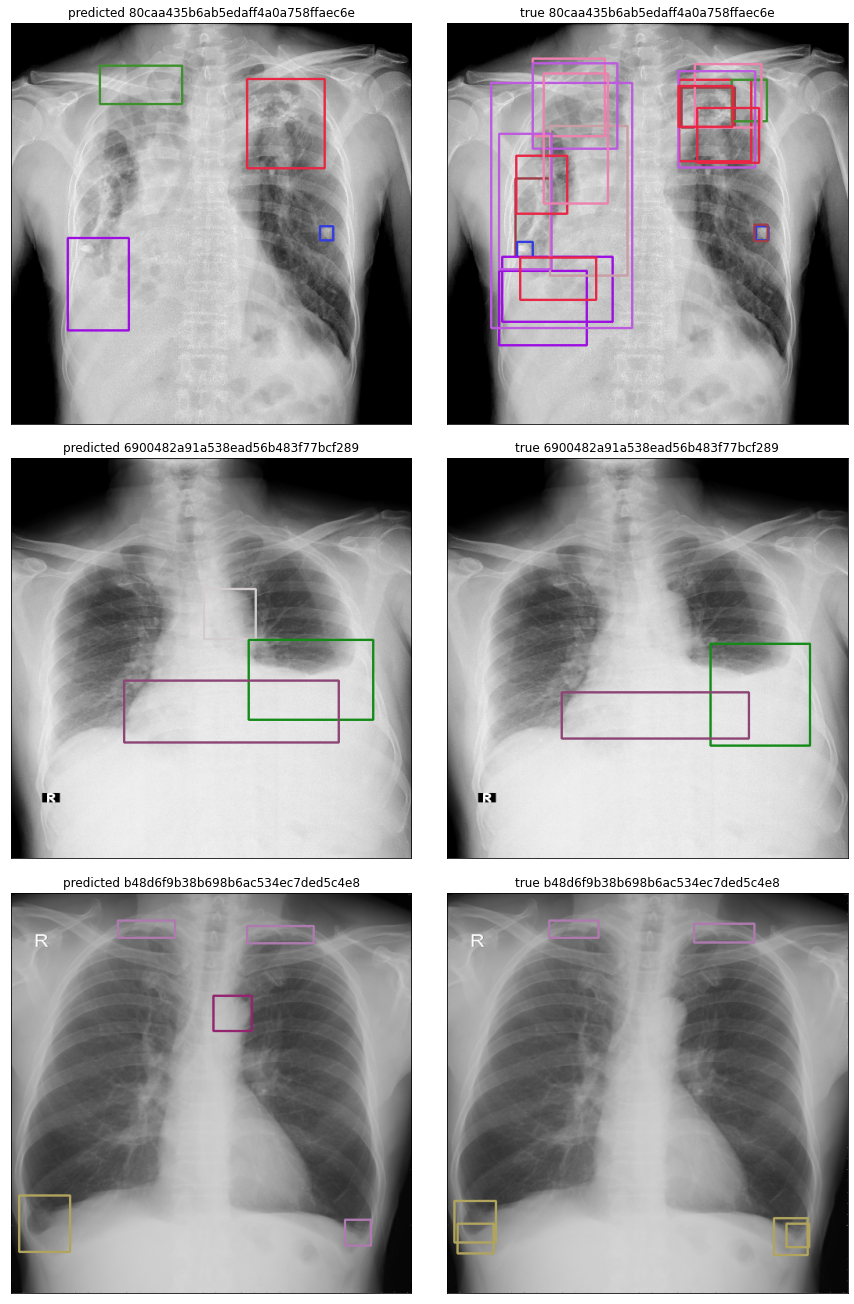

In [ ]:
iterable = iter(valid_loader)

images, target, im_ids = next(iterable)
images = list(image.to(cpu_device) for image in images)
outputs = lit_model(images)
fig, ax = plt.subplots(len(images), 2, figsize = (2*6,3*6), constrained_layout = True)
for i in range(len(images)):
  img_id = im_ids[i]
  img = images[i].permute(1,2,0).cpu().numpy()
  target_boxes = target[i]['boxes'].data.cpu().numpy()
  target_labels = target[i]['labels'].data.cpu().numpy().astype(int)
  boxes = outputs[i]['boxes'].data.cpu().numpy()
  scores = outputs[i]['scores'].data.cpu().numpy()
  labels = outputs[i]['labels'].data.cpu().numpy()
  boxes = boxes[scores>=detection_threshold]
  labels = labels[scores>=detection_threshold]
  labels = labels.astype(int)
  label2color = {class_id:[np.random.randint(0,255)/255 for i in range(3)] for class_id in np.unique(list(target_labels) + list(labels))}
  #img_predict = cv2.imread(f'/content/drive/MyDrive/Datasets/VinBigDataChestXray/train/train/{img_id}.jpg')
  #img_predict = cv2.cvtColor(img_pr2, cv2.COLOR_BGR2RGB)
  img_predict = img.copy()


  #img_true = cv2.imread(f'/content/drive/MyDrive/Datasets/VinBigDataChestXray/train/train/{img_id}.jpg')
  #img_true = cv2.cvtColor(img_true, cv2.COLOR_BGR2RGB)
  img_true = img.copy()
  

  thickness = 2
  for label_id, box in zip(target_labels, target_boxes):
    color1 = label2color[label_id]
    img_true = cv2.rectangle(
            img_true,
            (int(box[0]), int(box[1])),
            (int(box[2]), int(box[3])),
            color1, thickness
    )

  for label_id, box in zip(labels, boxes):
    color2 = label2color[label_id]
    img_predict = cv2.rectangle(
            img_predict,
            (int(box[0]), int(box[1])),
            (int(box[2]), int(box[3])),
            color2, thickness
    )

  ax[i][0].imshow(img_predict)
  ax[i][0].set_xticks([])
  ax[i][0].set_yticks([])
  ax[i][0].set_title(f'predicted {img_id}', fontsize = 12)

  ax[i][1].imshow(img_true)
  ax[i][1].set_xticks([])
  ax[i][1].set_yticks([])
  ax[i][1].set_title(f'true {img_id}', fontsize = 12)

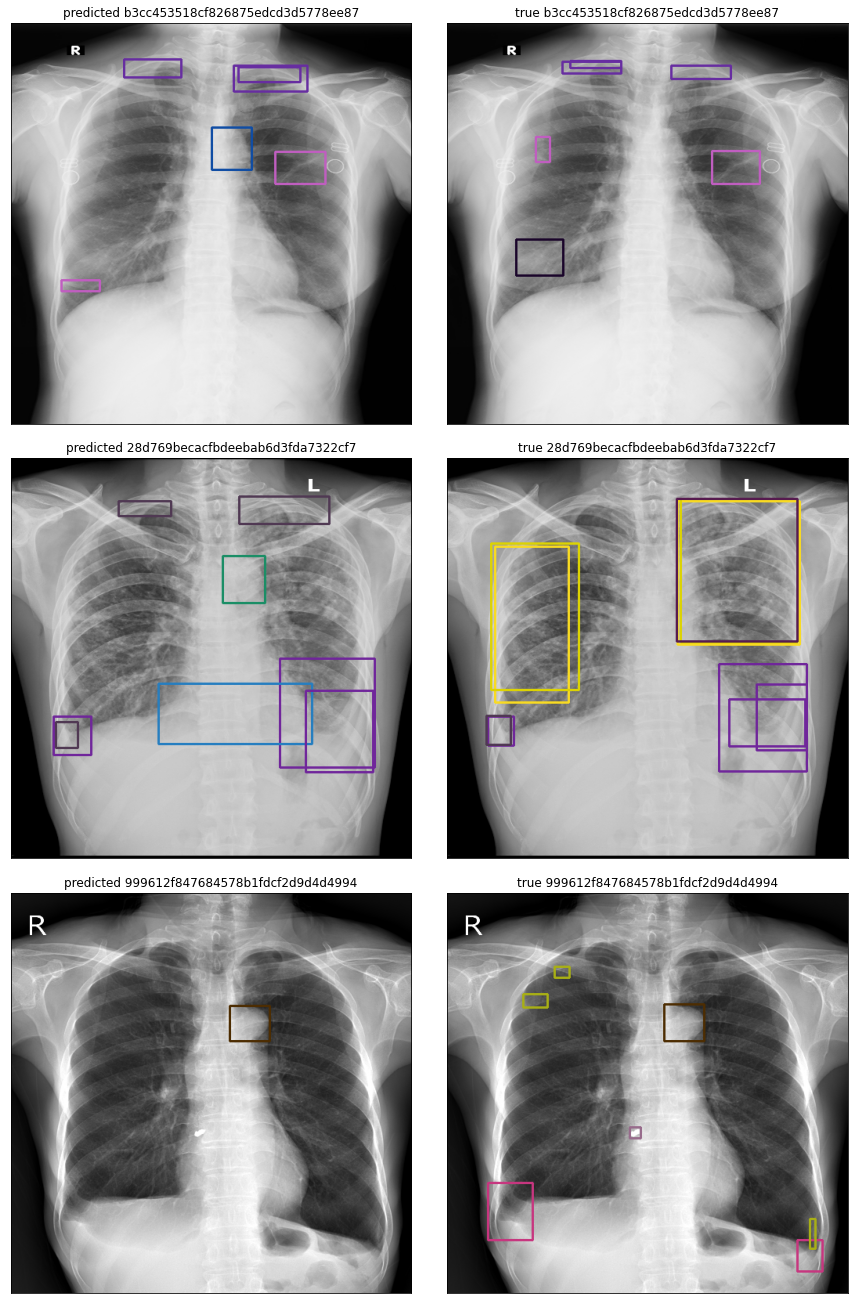

In [ ]:
images, target, im_ids = next(iterable)
images = list(image.to(cpu_device) for image in images)
outputs = lit_model(images)
fig, ax = plt.subplots(len(images), 2, figsize = (2*6,3*6), constrained_layout = True)
for i in range(len(images)):
  img_id = im_ids[i]
  img = images[i].permute(1,2,0).cpu().numpy()
  target_boxes = target[i]['boxes'].data.cpu().numpy()
  target_labels = target[i]['labels'].data.cpu().numpy().astype(int)
  boxes = outputs[i]['boxes'].data.cpu().numpy()
  scores = outputs[i]['scores'].data.cpu().numpy()
  labels = outputs[i]['labels'].data.cpu().numpy()
  boxes = boxes[scores>=detection_threshold]
  labels = labels[scores>=detection_threshold]
  labels = labels.astype(int)
  label2color = {class_id:[np.random.randint(0,255)/255 for i in range(3)] for class_id in np.unique(list(target_labels) + list(labels))}
  #img_predict = cv2.imread(f'/content/drive/MyDrive/Datasets/VinBigDataChestXray/train/train/{img_id}.jpg')
  #img_predict = cv2.cvtColor(img_pr2, cv2.COLOR_BGR2RGB)
  img_predict = img.copy()


  #img_true = cv2.imread(f'/content/drive/MyDrive/Datasets/VinBigDataChestXray/train/train/{img_id}.jpg')
  #img_true = cv2.cvtColor(img_true, cv2.COLOR_BGR2RGB)
  img_true = img.copy()
  

  thickness = 2
  for label_id, box in zip(target_labels, target_boxes):
    color1 = label2color[label_id]
    img_true = cv2.rectangle(
            img_true,
            (int(box[0]), int(box[1])),
            (int(box[2]), int(box[3])),
            color1, thickness
    )

  for label_id, box in zip(labels, boxes):
    color2 = label2color[label_id]
    img_predict = cv2.rectangle(
            img_predict,
            (int(box[0]), int(box[1])),
            (int(box[2]), int(box[3])),
            color2, thickness
    )

  ax[i][0].imshow(img_predict)
  ax[i][0].set_xticks([])
  ax[i][0].set_yticks([])
  ax[i][0].set_title(f'predicted {img_id}', fontsize = 12)

  ax[i][1].imshow(img_true)
  ax[i][1].set_xticks([])
  ax[i][1].set_yticks([])
  ax[i][1].set_title(f'true {img_id}', fontsize = 12)